In [1]:
import os

In [2]:
from scipy.stats import spearmanr, pearsonr, gaussian_kde
import numpy as np
import pandas as pd

In [3]:
import sqlite3 as lite 

In [4]:
from glob import glob
from matplotlib import pyplot as plt
plt.rcParams["font.family"] = "Arial Narrow"

# Load compartments

In [5]:
treatments = ['NUT']
conditions = ['WT']
times = ['0h', '1h', '4h', '7h', '10h', '24h', 'w24h']

In [6]:
db_path = '../../data/ComplementaryData/HiC/TADbit_results/'

In [7]:
windows = [3]
ev_indexes = [1, 2]

In [8]:
hashs = {}
wjobids = {}
samples = []
for treatment in treatments:
    for condition in conditions:
        for time in times:
            sample = condition, treatment, time
            try:
                con = lite.connect(os.path.join(
                    db_path, f'Cabrera_2022_HCT116_{condition}_{treatment}_{time}/trace.db'))
            except lite.OperationalError:
                print(f'Error {sample}')
                continue
            print(os.path.join(
                    db_path, f'Cabrera_2022_HCT116_{condition}_{treatment}_{time}/trace.db'))
            hashs[sample] = {}
            wjobids[sample] = {}
            samples.append(sample)
            cur = con.cursor()
            cur.execute("""
            select distinct Id, Parameters, Parameters_md5 from JOBs
            where Type = 'Segment' AND parameters like '%compartments:1%' AND not parameters like '%crms:[chrY]%'
            """)
            jobids = cur.fetchall()
            for window in windows:
                hashs[sample][window] = {}
                wjobids[sample][window] = {}
                for ev_index in ev_indexes:
                    if ev_index == 1:
                        test_ev = lambda x: 'ev_index:[2]' not in x
                    else:
                        test_ev = lambda x: 'ev_index:[2]' in x
                    hashs[sample][window][ev_index] = {}
                    wjobids[sample][window][ev_index] = {}
                    for jobid, parameters, md5 in jobids:
                        if (test_ev(parameters) and
                           f'smoothing_window:{window}' in parameters):
                            c = parameters.split('crms:[')[1].split(']')[0]
                            hashs[sample][window][ev_index][c] = md5
                            wjobids[sample][window][ev_index][c] = jobid
            con.close()
            con = lite.connect(os.path.join(
                db_path, f'Cabrera_2022_HCT116_{condition}_{treatment}_{time}/trace.db'))
            cur = con.cursor()
            cur.execute("""
            select distinct JOBid, richA_corr from SEGMENT_OUTPUTs where Resolution = 100000 and Chromosome != "chrY"
            """)
            jobids = dict(cur.fetchall())
            for window in windows:
                for ev_index in ev_indexes:
                    for c in wjobids[sample][window][ev_index]:
                        wjobids[sample][window][ev_index][c] = abs(
                            jobids[wjobids[sample][window][ev_index][c]])
            con.close()


../../data/ComplementaryData/HiC/TADbit_results/Cabrera_2022_HCT116_WT_NUT_0h/trace.db
../../data/ComplementaryData/HiC/TADbit_results/Cabrera_2022_HCT116_WT_NUT_1h/trace.db
../../data/ComplementaryData/HiC/TADbit_results/Cabrera_2022_HCT116_WT_NUT_4h/trace.db
../../data/ComplementaryData/HiC/TADbit_results/Cabrera_2022_HCT116_WT_NUT_7h/trace.db
../../data/ComplementaryData/HiC/TADbit_results/Cabrera_2022_HCT116_WT_NUT_10h/trace.db
../../data/ComplementaryData/HiC/TADbit_results/Cabrera_2022_HCT116_WT_NUT_24h/trace.db
../../data/ComplementaryData/HiC/TADbit_results/Cabrera_2022_HCT116_WT_NUT_w24h/trace.db


In [9]:
for t in hashs:
    for w in windows:
        for e in ev_indexes:
            print('{}\t{} ({})\t{}'.format(t, w, e, len(hashs[t][w][e])))

('WT', 'NUT', '0h')	3 (1)	23
('WT', 'NUT', '0h')	3 (2)	23
('WT', 'NUT', '1h')	3 (1)	23
('WT', 'NUT', '1h')	3 (2)	23
('WT', 'NUT', '4h')	3 (1)	23
('WT', 'NUT', '4h')	3 (2)	23
('WT', 'NUT', '7h')	3 (1)	23
('WT', 'NUT', '7h')	3 (2)	23
('WT', 'NUT', '10h')	3 (1)	23
('WT', 'NUT', '10h')	3 (2)	23
('WT', 'NUT', '24h')	3 (1)	23
('WT', 'NUT', '24h')	3 (2)	23
('WT', 'NUT', 'w24h')	3 (1)	23
('WT', 'NUT', 'w24h')	3 (2)	23


In [10]:
cpath = os.path.join(
    db_path, 
    'Cabrera_2022_HCT116_{}_{}_{}/06_segmentation/compartments_100kb/{}_EigVect{}_{}.tsv')

In [11]:
chromosomes = [f'chr{c}' for c in list(range(1, 23)) + ['X']]

In [12]:
h = 'hash'
evs = {}
for params in hashs:
    evs[params] = {}
    for w in windows:
        evs[params][w] = {}
        for nev in ev_indexes:
            evs[params][w][nev] = {}
            for c in chromosomes:
                evs[params][w][nev][c] = {}
                try:
                    fh = open(cpath.format(*params, c, nev, hashs[params][w][nev][c]))
                except KeyError:
                    print('MISSING:', params, w, nev, c)
                    continue
                next(fh)
                for nl, line in enumerate(fh):
                    ev = line.split('\t')[nev - 1]
                    evs[params][w][nev][c][nl] = float(ev)

## Find best correlation between replicates

In [13]:
def nan_pearsonr(x, y):
    return pearsonr(*list(zip(*[(i, j) for i, j in zip(x, y) if np.isfinite(i) and np.isfinite(j)])))

In [14]:
evs.keys()

dict_keys([('WT', 'NUT', '0h'), ('WT', 'NUT', '1h'), ('WT', 'NUT', '4h'), ('WT', 'NUT', '7h'), ('WT', 'NUT', '10h'), ('WT', 'NUT', '24h'), ('WT', 'NUT', 'w24h')])

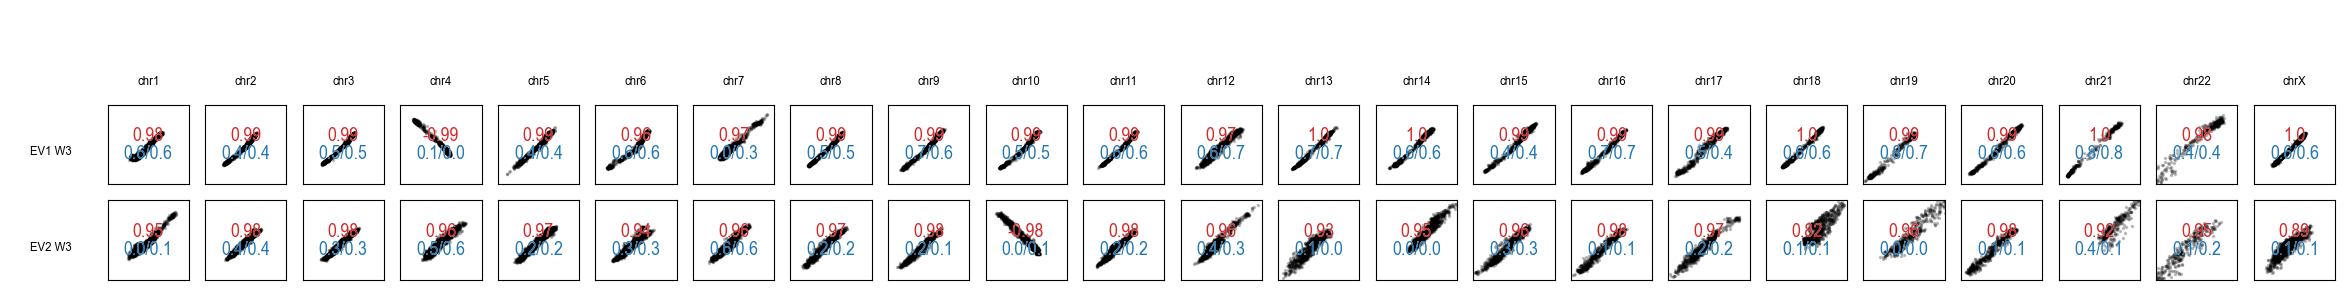

In [15]:
plt.figure(figsize=(30, 6))
nplot = 2
for c in chromosomes:
    plt.subplot(5, 24, nplot)
    plt.text(0, 0, c, va='center', ha='center')
    plt.xlim(-1, 1)
    plt.ylim(-.1, 1)
    plt.axis('off')
    nplot += 1
for e in ev_indexes:
    for w in windows:
        plt.subplot(5, 24, nplot)
        plt.text(0, 0, f'{""}\nEV{e} W{w}', va='center', ha='center')
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        plt.axis('off')
        nplot += 1
        for c in chromosomes:
            x = list(evs['WT', 'NUT'  , '0h'][w][e][c].values())
            y = list(evs['WT', 'NUT', '10h'][w][e][c].values())
            if not x or not y:
                x = y = [0, 0]
            if len(x) != len(y):
                if len(x) < len(y):
                    x.extend([float('nan')] * (len(y) - len(x)))
                else:
                    y.extend([float('nan')] * (len(x) - len(y)))
            R, pv = nan_pearsonr(x, y)
            C1 = wjobids['WT', 'NUT'  , '0h'][w][e][c]
            C2 = wjobids['WT', 'NUT', '10h'][w][e][c]
            plt.subplot(5, 24, nplot)
            nplot += 1
            plt.plot(x, y, 'k.', alpha=0.2, ms=3)
            plt.text(0, 0, round(R, 2), color='white', 
                     size=14, va='bottom', ha='center', weight='bold')
            plt.text(0, 0, round(R, 2), color='tab:red', 
                     size=14, va='bottom', ha='center')
            plt.text(0, 0, '{:.1f}/{:.1f}'.format(C1, C2), color='white', 
                     size=14, va='top', ha='center', weight='bold')
            plt.text(0, 0, '{:.1f}/{:.1f}'.format(C1, C2), color='tab:blue',
                     size=14, va='top', ha='center')
            plt.xticks([])
            plt.yticks([])
            plt.xlim(-.1, .1)
            plt.ylim(-.1, .1)


### Best Window should be 3, and cis/trans Ratio of 1 is the best

In [16]:
hashs.keys()

dict_keys([('WT', 'NUT', '0h'), ('WT', 'NUT', '1h'), ('WT', 'NUT', '4h'), ('WT', 'NUT', '7h'), ('WT', 'NUT', '10h'), ('WT', 'NUT', '24h'), ('WT', 'NUT', 'w24h')])

In [17]:
comparisons = [
    (('WT', 'NUT', '0h'  ), ('WT', 'NUT' , '10h')),
    (('WT', 'NUT', '1h'  ), ('WT', 'NUT' , '10h')),
    (('WT', 'NUT', '4h'  ), ('WT', 'NUT' , '10h')),
    (('WT', 'NUT', '7h'  ), ('WT', 'NUT' , '10h')),
    (('WT', 'NUT', '24h' ), ('WT', 'NUT' , '10h')),
    (('WT', 'NUT', 'w24h'), ('WT', 'NUT' , '10h')),
#     (('WT', 'NUT', 'w48h'), ('WT', 'NUT' , '10h')),
]

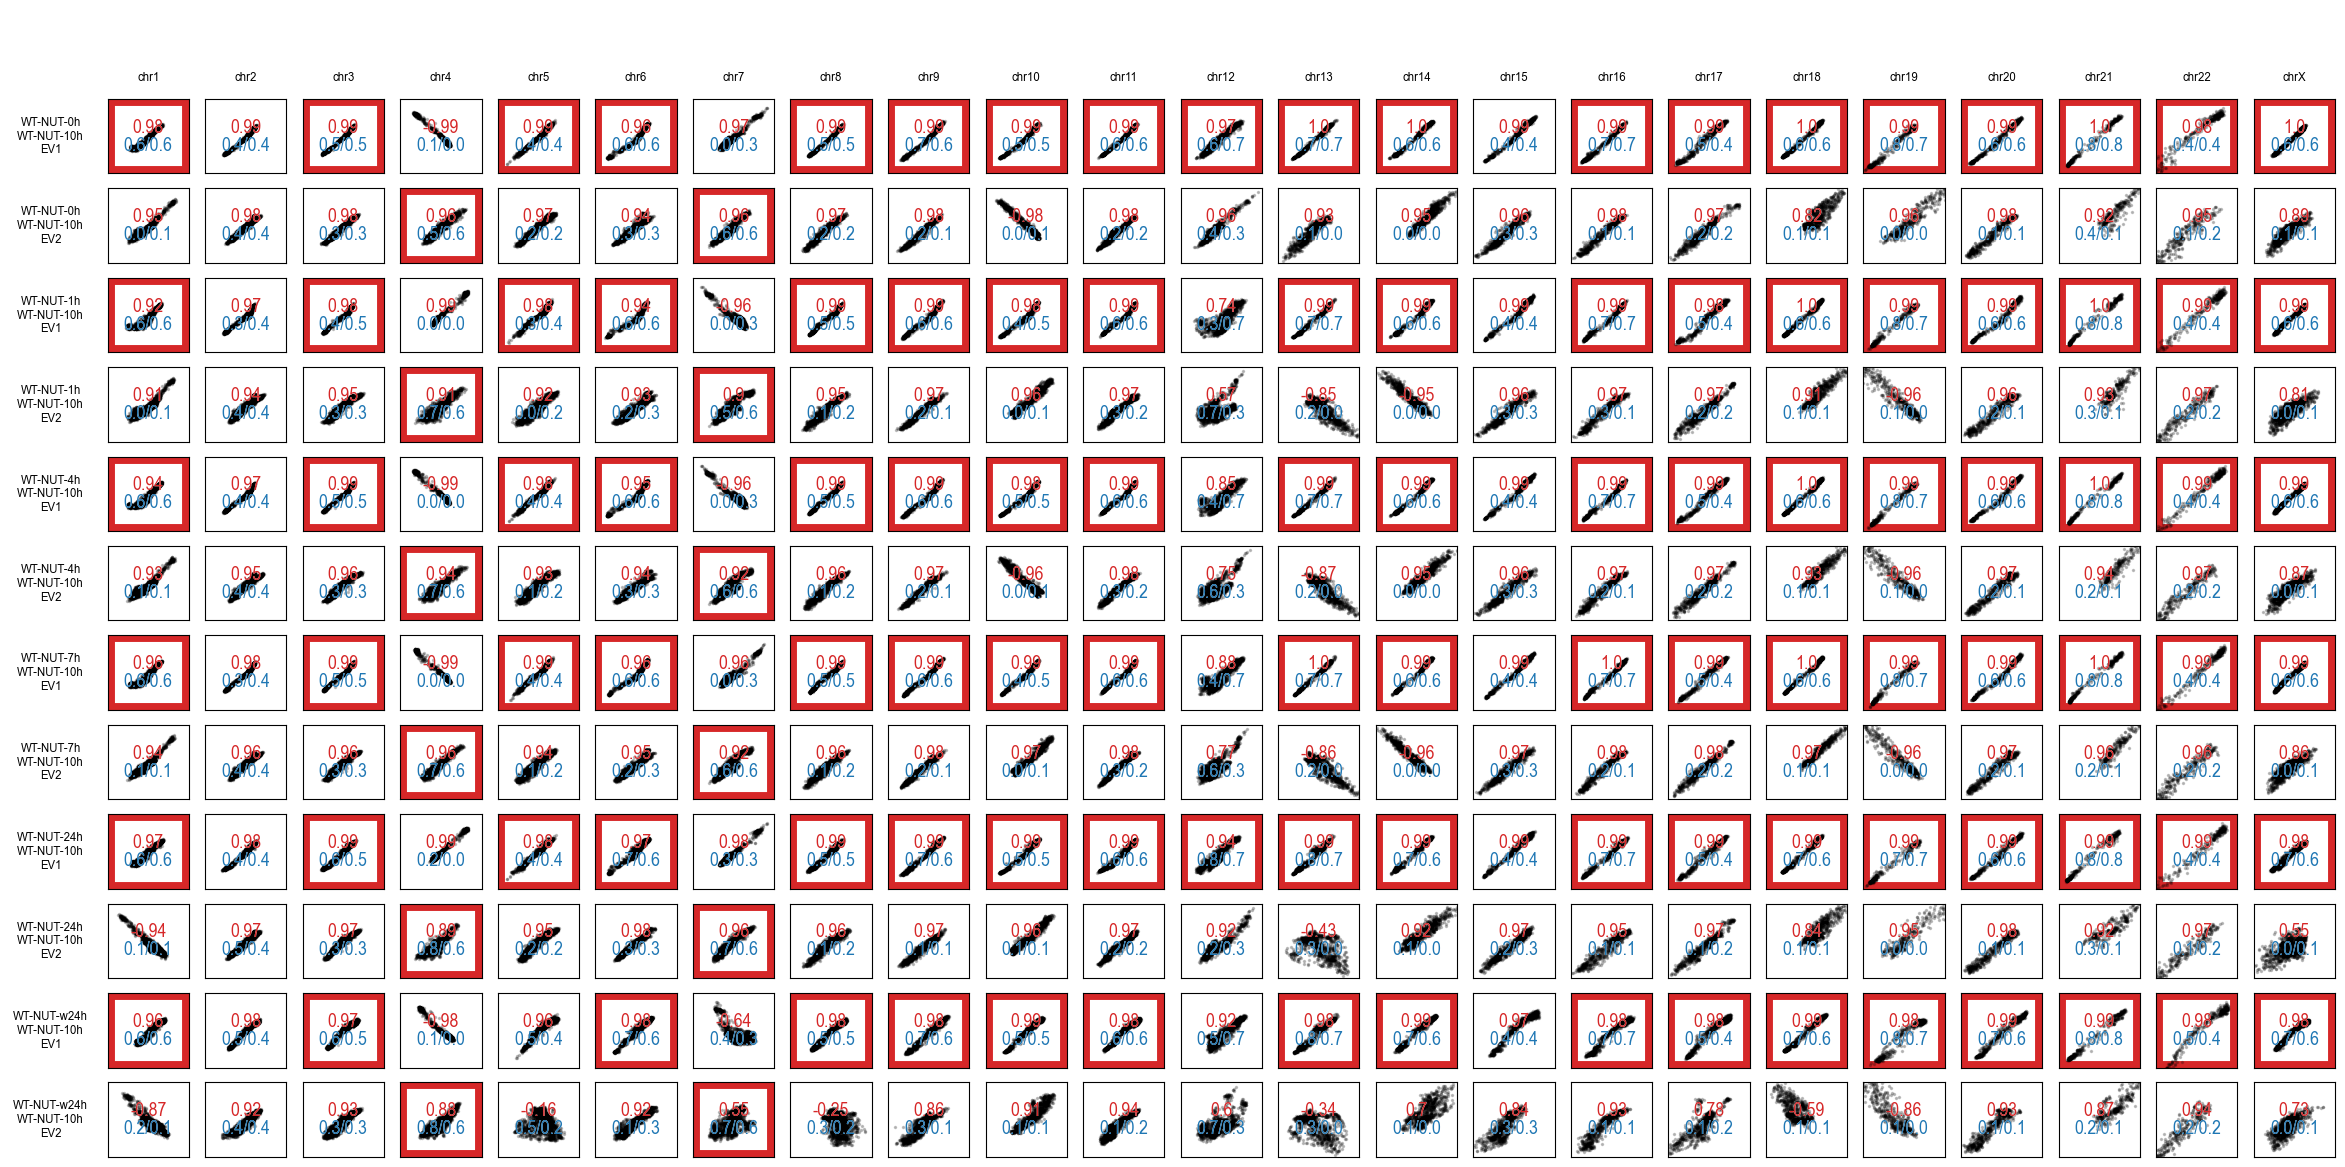

In [18]:
plt.figure(figsize=(30, 30))
nplot = 2
for c in chromosomes:
    plt.subplot(26, 24, nplot)
    plt.text(0, 0, c, va='center', ha='center')
    plt.xlim(-1, 1)
    plt.ylim(-.1, 1)
    plt.axis('off')
    nplot += 1
w = 3
for p1, p2 in comparisons:
    for e in ev_indexes:
        plt.subplot(26, 24, nplot)
        plt.text(0, 0, f'{"-".join(p1)}\n{"-".join(p2)}\nEV{e}', va='center', ha='center')
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        plt.axis('off')
        nplot += 1
        for c in chromosomes:
            x = list(evs[p1][w][e][c].values())
            y = list(evs[p2][w][e][c].values())
            if not x or not y:
                x = y = [0, 0]
            if len(x) != len(y):
                if len(x) < len(y):
                    x.extend([float('nan')] * (len(y) - len(x)))
                else:
                    y.extend([float('nan')] * (len(x) - len(y)))
            R, pv = nan_pearsonr(x, y)
            C1 = wjobids[p1][w][e][c]
            C2 = wjobids[p2][w][e][c]
            plt.subplot(26, 24, nplot)


            otherC1 = wjobids[p1][w][1 if e == 2 else 2][c]
            otherC2 = wjobids[p2][w][1 if e == 2 else 2][c]
            if C1 > otherC1 * 1.3 and C2 > otherC2 * 1.3:
                plt.plot([-0.1, -0.1, 0.1, 0.1, -0.1], [-0.1, 0.1, 0.1, -0.1, -0.1], lw=10, color='tab:red')

            nplot += 1
            plt.plot(x, y, 'k.', alpha=0.2, ms=3)
            plt.text(0, 0, round(R, 2), color='white', 
                     size=14, va='bottom', ha='center', weight='bold')
            plt.text(0, 0, round(R, 2), color='tab:red', 
                     size=14, va='bottom', ha='center')
            plt.text(0, 0, '{:.1f}/{:.1f}'.format(C1, C2), color='white', 
                     size=14, va='top', ha='center', weight='bold')
            plt.text(0, 0, '{:.1f}/{:.1f}'.format(C1, C2), color='tab:blue',
                     size=14, va='top', ha='center')
            plt.xticks([])
            plt.yticks([])
            plt.xlim(-.1, .1)
            plt.ylim(-.1, .1)


## manually define which EV to choose

In [19]:
which_ev = {
    ('0h'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('1h'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('4h'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('7h'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('10h'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('24h'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('w24h'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    },
    ('w48h'): {
        'chr2' : 1,  # manual inspection
        'chr4' : 2,
        'chr7' : 2,
        'chr12': 1,  # manual inspection
    }
}

In [20]:
w = 3
raw_evs = {}
for sample in hashs:
    raw_evs[sample] = {}
    for c in chromosomes:
        nev = which_ev[sample[2]].get(c, 1)
        raw_evs[sample][c] = evs[sample][w][nev][c]

In [21]:
for n, c in enumerate(chromosomes, 1):
    len_max = max(len(raw_evs[s][c].values()) for s in hashs)
    for s in hashs:
        len_other = len(raw_evs[s][c].values())
        if len_max != len_other:
            for i in range(len_other + 1, len_max + 1):
                raw_evs[s][c][i] = float('nan')

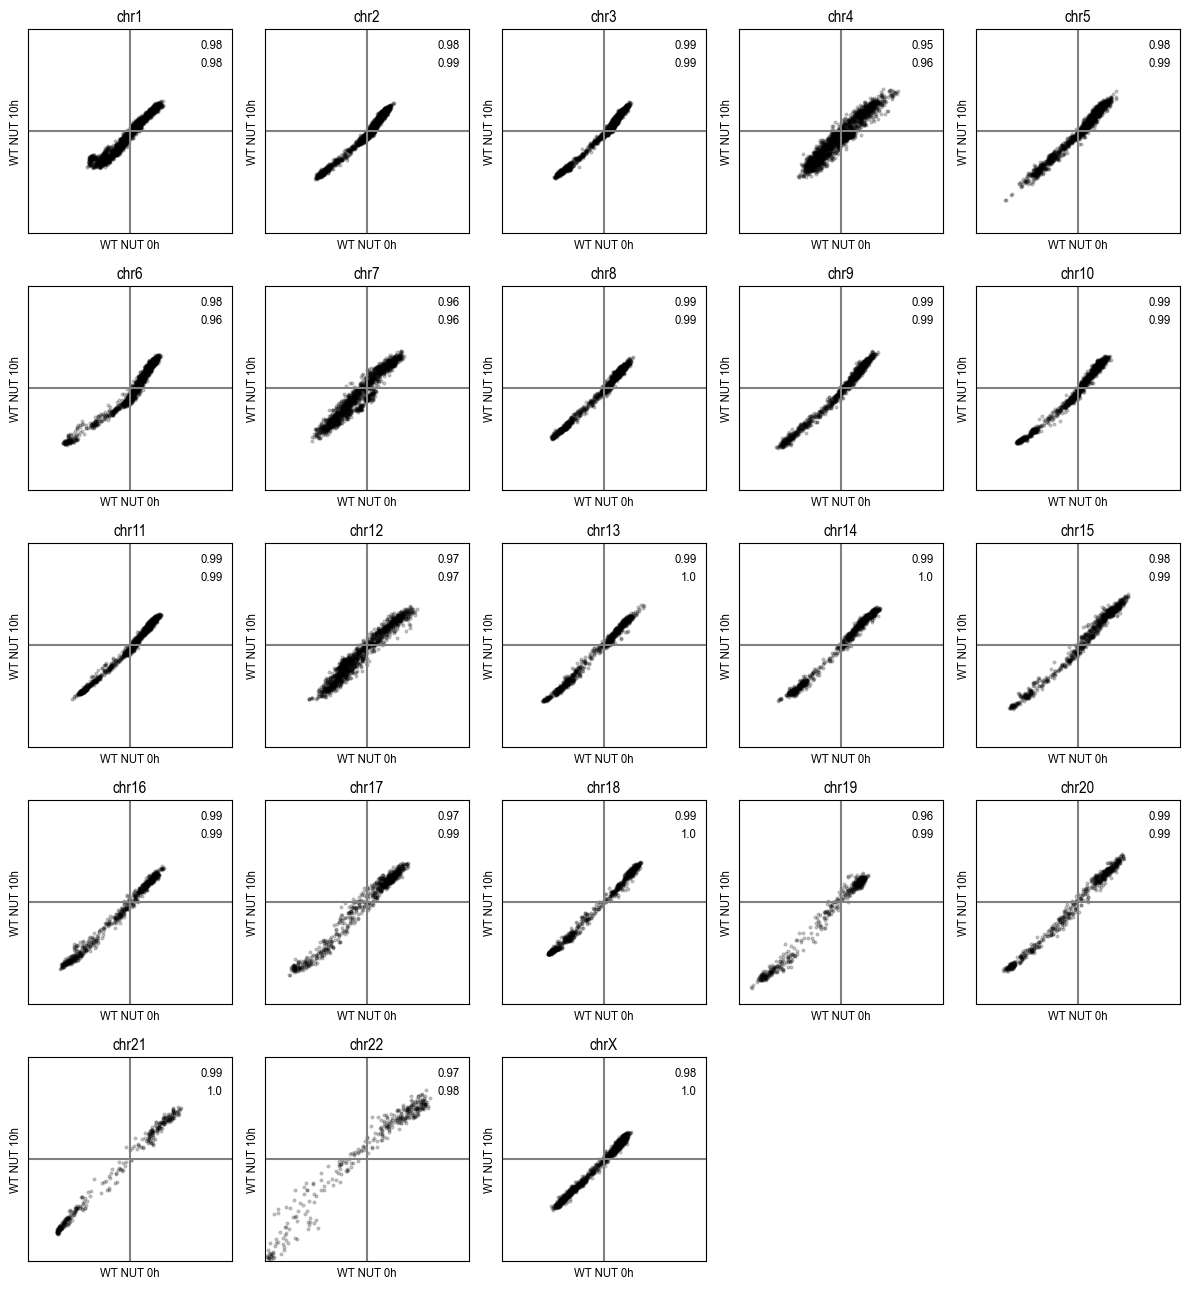

In [22]:
plt.figure(figsize=(12, 13))
for n, c in enumerate(chromosomes, 1):
    plt.subplot(5, 5, n)
    x = list(raw_evs['WT', 'NUT', '0h'][c].values())
    y = list(raw_evs['WT', 'NUT', '10h'][c].values())
    r, pv = spearmanr(*zip(*([(i, j) for i, j in zip(x, y) if np.isfinite(i) and np.isfinite(j)])))
    plt.text(.1, .1, round(r, 2), va='top', ha='right')
    r, pv = pearsonr(*zip(*([(i, j) for i, j in zip(x, y) if np.isfinite(i) and np.isfinite(j)])))
    plt.text(.1, .08, round(r, 2), va='top', ha='right')
    plt.plot(x, y, 'k.', alpha=0.2, ms=4)
    plt.xlabel('WT NUT 0h')
    plt.ylabel('WT NUT 10h')
    plt.axvline(0, color='grey')
    plt.axhline(0, color='grey')
    plt.xticks([])
    plt.yticks([])
    plt.xlim(-0.11, 0.11)
    plt.ylim(-0.11, 0.11)
    plt.title(c)
plt.tight_layout()

# normalize EVs

In [23]:
norm_evs = {}
for condition in hashs:
    norm_evs[condition] = {}
    for n, c in enumerate(chromosomes, 1):
        x = list(raw_evs[condition][c].values())
        minx, maxx = np.nanpercentile(x, [1, 99])
        norm_evs[condition][c] = dict((i, -v / minx if v < 0 else v / maxx)  for i, v in enumerate(x))

In [24]:
norm_evs = {}
for condition in hashs:
    norm_evs[condition] = {}
    for n, c in enumerate(chromosomes, 1):
        x = list(raw_evs[condition][c].values())
        minx, maxx = np.nanpercentile(x, [1, 99])
        absmax = max(maxx, -minx)
        norm_evs[condition][c] = dict((i, v / absmax)  for i, v in enumerate(x))

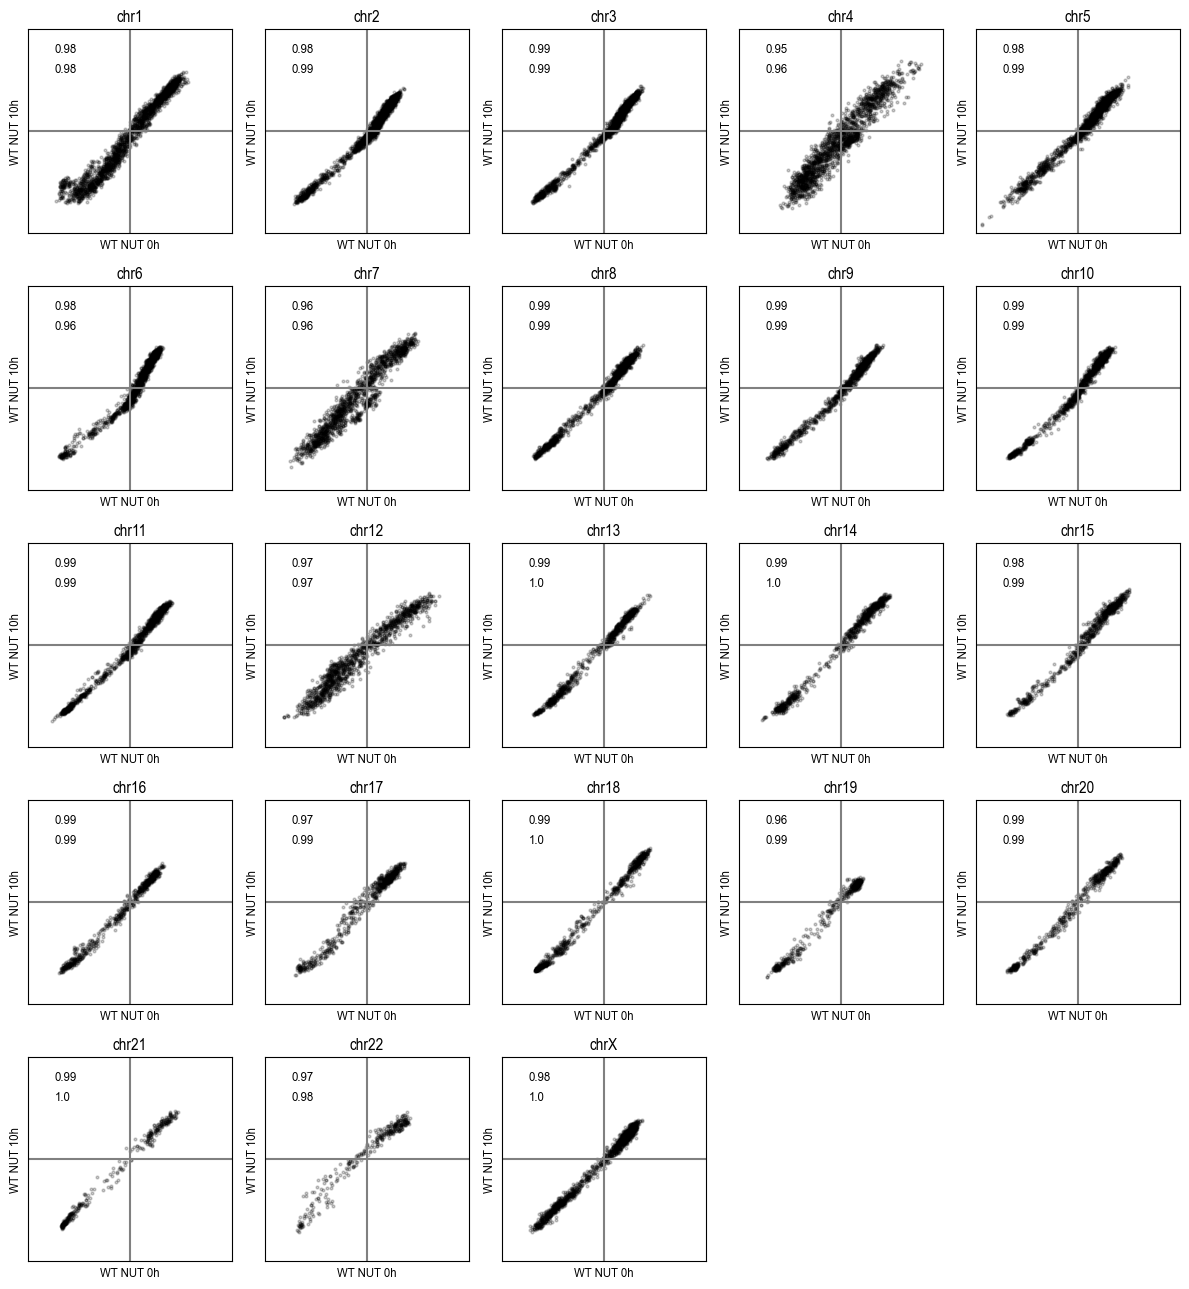

In [25]:
plt.figure(figsize=(12, 13))
X = []
Y = []
for n, c in enumerate(chromosomes, 1):
    plt.subplot(5, 5, n)
    x = norm_evs['WT', 'NUT', '0h'][c].values()
    y = norm_evs['WT', 'NUT', '10h'][c].values()
    r, pv = spearmanr(*zip(*([(i, j) for i, j in zip(x, y) if np.isfinite(i) and np.isfinite(j)])))
    plt.text(-1.1, 1.3, round(r, 2), va='top', ha='left')
    r, pv = pearsonr(*zip(*([(i, j) for i, j in zip(x, y) if np.isfinite(i) and np.isfinite(j)])))
    plt.text(-1.1, 1.0, round(r, 2), va='top', ha='left')
    plt.plot(x, y, 'k.', alpha=0.2, ms=4)
    X.extend(x)
    Y.extend(y)
    plt.xlabel('WT NUT 0h')
    plt.ylabel('WT NUT 10h')
    plt.axvline(0, color='grey')
    plt.axhline(0, color='grey')
    plt.xticks([])
    plt.yticks([])
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.title(c)
plt.tight_layout()

## Save EVs

In [26]:
from pickle import dump

In [27]:
# out = open('eigenvectors_selected_raw.pickle', 'wb')
# dump(raw_evs, out)
# out.close()

In [28]:
# out = open('eigenvectors_selected_normalized.pickle', 'wb')
# dump(norm_evs, out)
# out.close()

# plot EVs

<Figure size 1300x500 with 0 Axes>

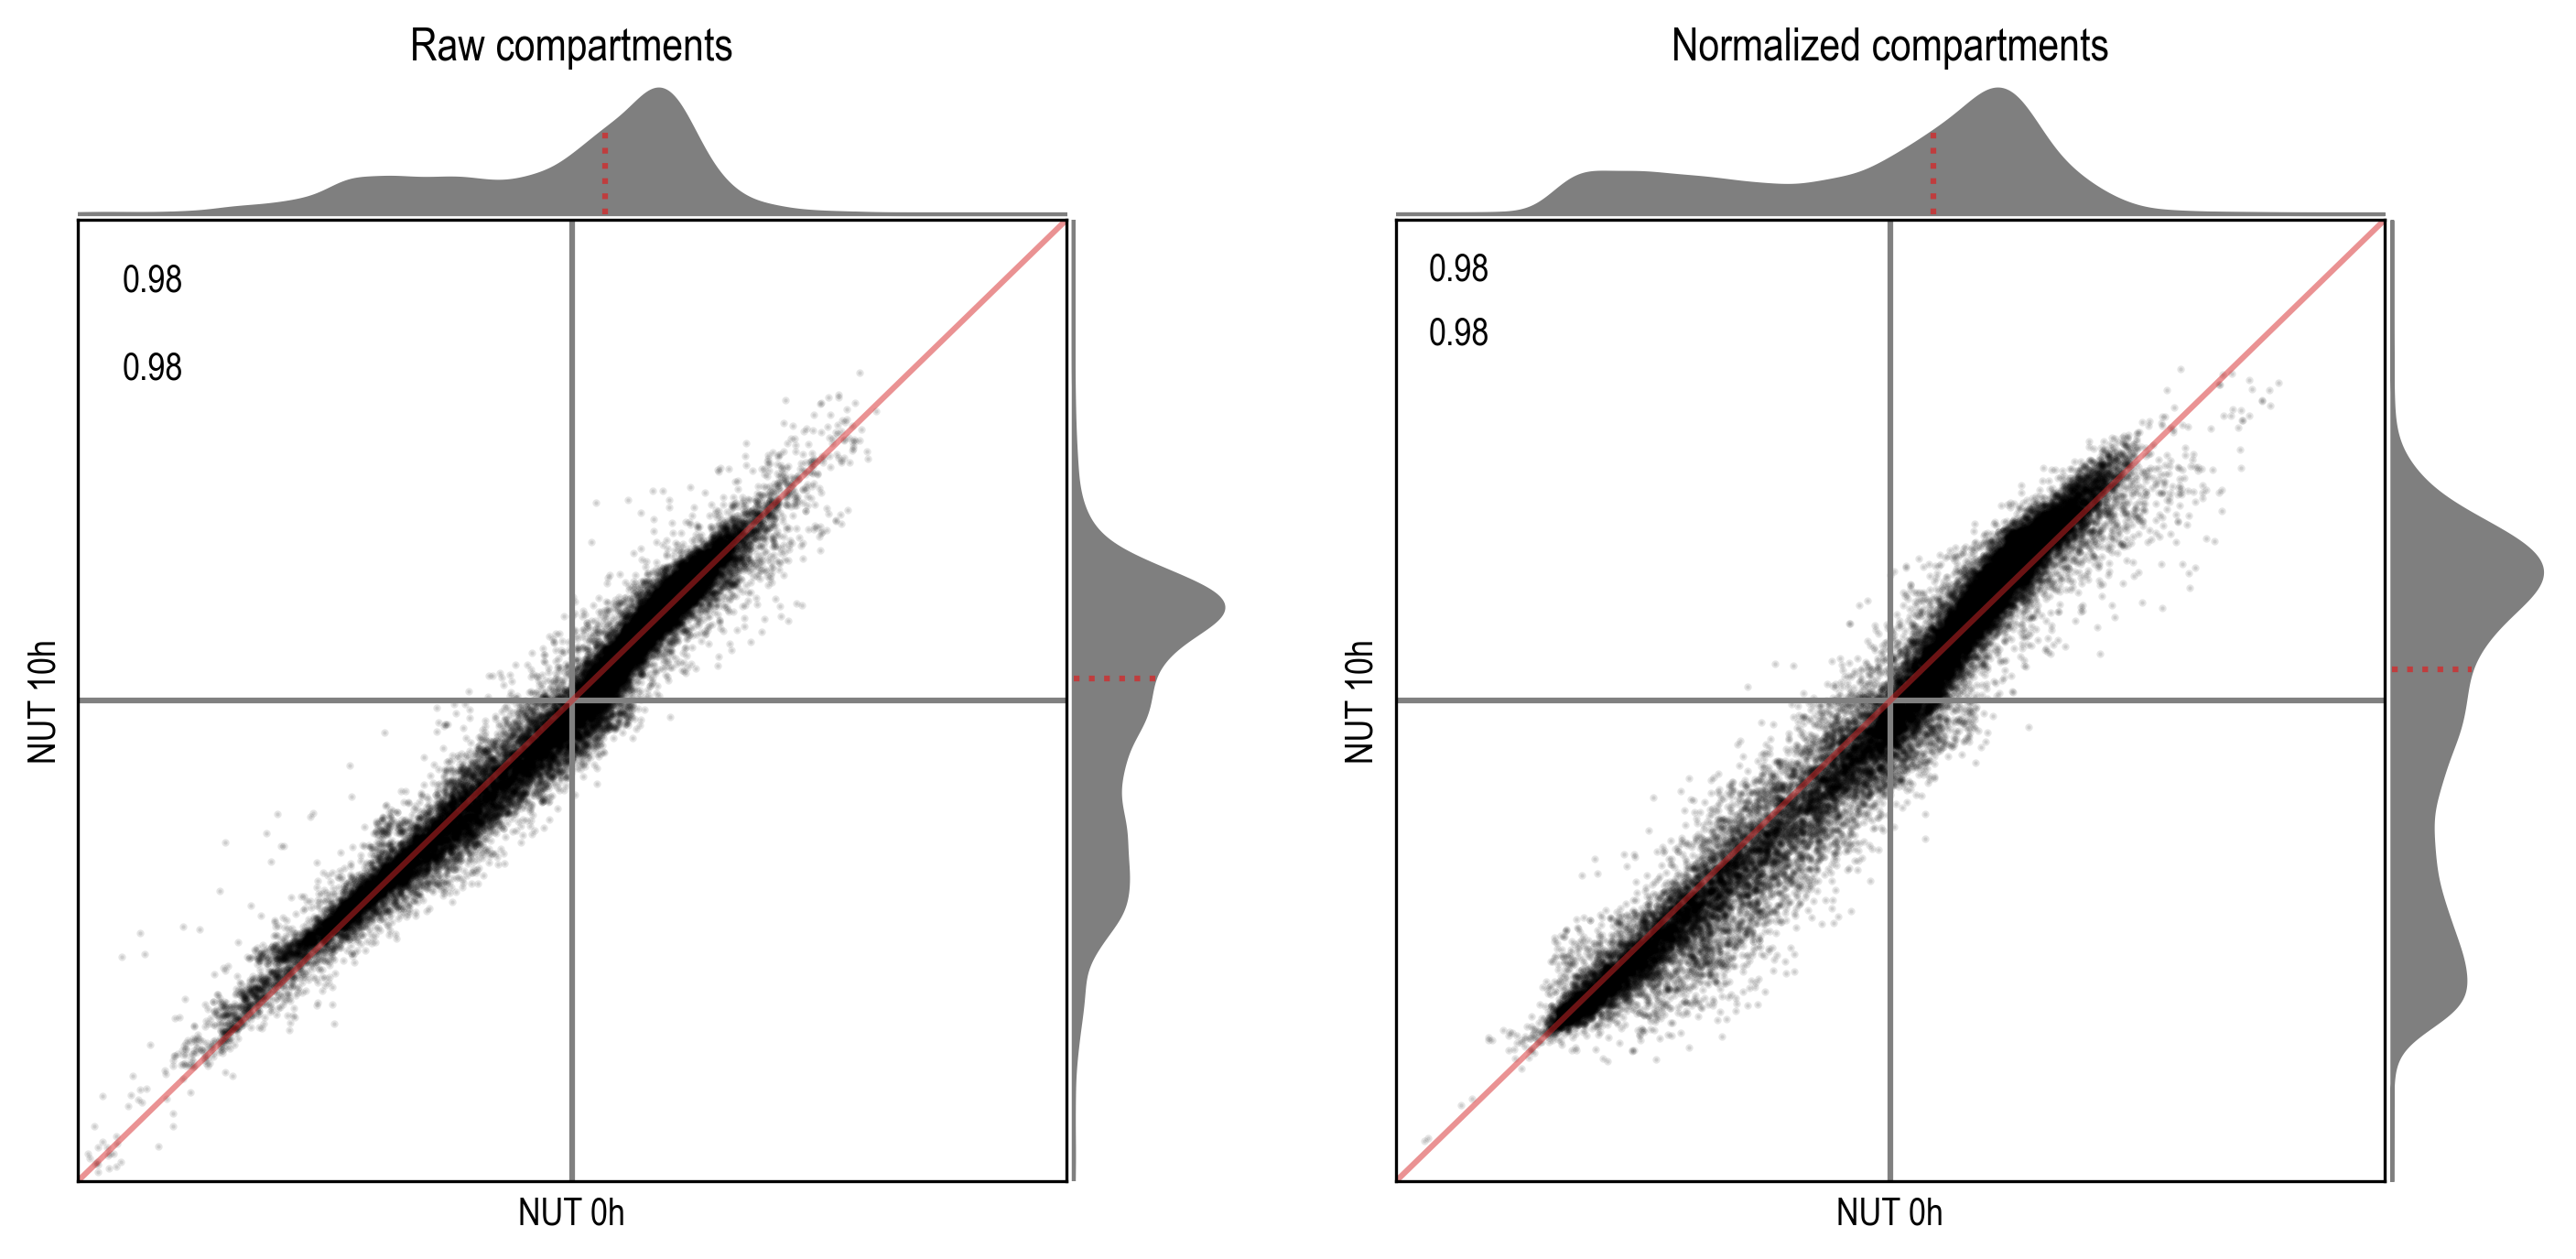

In [29]:
plt.figure(figsize=(13, 5))

fig, axes = plt.subplots(1,6, figsize=(12,5), dpi=300)
axe1, axe2, axe1u, axe1r, axe2u, axe2r = axes

axe1.set_position((0.1, 0.1, 0.3, 0.7))
axe1u.set_position((0.1, 0.8, 0.3, 0.1))
axe1r.set_position((0.4, 0.1, 0.05, 0.7))
axe2.set_position((0.5, 0.1, 0.3, 0.7))
axe2u.set_position((0.5, 0.8, 0.3, 0.1))
axe2r.set_position((0.8, 0.1, 0.05, 0.7))
axe1u.axis('off')
axe1r.axis('off')
axe2u.axis('off')
axe2r.axis('off')


axe1.sharex(axe1u)
axe1.sharey(axe1r)
axe2.sharex(axe2u)
axe2.sharey(axe2r)


X = []
Y = []
for n, c in enumerate(chromosomes, 1):
    x = raw_evs['WT', 'NUT'  , '0h'][c].values()
    y = raw_evs['WT', 'NUT', '10h'][c].values()
    X.extend(x)
    Y.extend(y)
r, pv = spearmanr(*zip(*([(i, j) for i, j in zip(X, Y) if np.isfinite(i) and np.isfinite(j)])))
axe1.text(-.1, .1, round(r, 2), va='top', ha='left')
r, pv = pearsonr(*zip(*([(i, j) for i, j in zip(X, Y) if np.isfinite(i) and np.isfinite(j)])))
axe1.text(-.1, .08, round(r, 2), va='top', ha='left')
axe1.plot(X, Y, 'k.', alpha=0.1, ms=2)
axe1.set_xlabel('NUT 0h')
axe1.set_ylabel('NUT 10h')
axe1.axvline(0, color='grey')
axe1.axhline(0, color='grey')
axe1.set_xticks([])
axe1.set_yticks([])
axe1.plot([-10, 10], [-10, 10], 'tab:red', alpha=0.5)
axe1.set_xlim(-0.11, 0.11)
axe1.set_ylim(-0.11, 0.11)

kde = gaussian_kde([v for v in X if np.isfinite(v)])
xx = np.linspace(-0.15, 0.15, 1000)
mx = np.nanmedian(X)
axe1u.plot([mx, mx], [0, kde(mx)[0]], 'tab:red', linestyle=':', alpha=0.75)
axe1u.fill_between(xx, kde(xx), color='tab:grey')
axe1u.set_title('Raw compartments')

kde = gaussian_kde([v for v in Y if np.isfinite(v)])
yy = np.linspace(-0.15, 0.15, 1000)
my = np.nanmedian(Y)
axe1r.plot([0, kde(my)[0]], [my, my], 'tab:red', linestyle=':', alpha=0.75)
axe1r.fill_betweenx(yy, kde(yy), color='tab:grey');

X = []
Y = []
for n, c in enumerate(chromosomes, 1):
    x = norm_evs['WT', 'NUT'  , '0h'][c].values()
    y = norm_evs['WT', 'NUT', '10h'][c].values()
    X.extend(x)
    Y.extend(y)
r, pv = spearmanr(*zip(*([(i, j) for i, j in zip(X, Y) if np.isfinite(i) and np.isfinite(j)])))
axe2.text(-1.4, 1.4, round(r, 2), va='top', ha='left')
r, pv = pearsonr(*zip(*([(i, j) for i, j in zip(X, Y) if np.isfinite(i) and np.isfinite(j)])))
axe2.text(-1.4, 1.2, round(r, 2), va='top', ha='left')
axe2.plot(X, Y, 'k.', alpha=0.1, ms=2)
axe2.set_xlabel('NUT 0h')
axe2.set_ylabel('NUT 10h')
axe2.axvline(0, color='grey')
axe2.axhline(0, color='grey')
axe2.set_xticks([])
axe2.set_yticks([])
axe2.plot([-10, 10], [-10, 10], 'tab:red', alpha=0.5)
axe2.set_xlim(-1.5, 1.5)
axe2.set_ylim(-1.5, 1.5)

kde = gaussian_kde([v for v in X if np.isfinite(v)])
xx = np.linspace(-1.5, 1.5, 1000)
mx = np.nanmedian(X)
axe2u.plot([mx, mx], [0, kde(mx)[0]], 'tab:red', linestyle=':', alpha=0.75)
axe2u.fill_between(xx, kde(xx), color='tab:grey')
axe2u.set_title('Normalized compartments')

kde = gaussian_kde([v for v in Y if np.isfinite(v)])
yy = np.linspace(-1.5, 1.5, 1000)
my = np.nanmedian(Y)
axe2r.plot([0, kde(my)[0]], [my, my], 'tab:red', linestyle=':', alpha=0.75)
axe2r.fill_betweenx(yy, kde(yy), color='tab:grey');